In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
% matplotlib inline
from geopy.distance import vincenty
from datetime import datetime, timedelta
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

In [43]:
dft = pd.read_csv('Crimes_-_2001_to_present.csv')

#Dummy 'Domestic' and 'Arrest' Columns
dft['Domestic'] = dft['Domestic'].apply(lambda x: 1 if x == True else 0)
dft['Arrest'] = dft['Arrest'].apply(lambda x: 1 if x ==True else 0)

#drop unneccesary columns
dft.drop('FBI Code', axis=1, inplace = True)
dft.drop('Updated On', axis=1, inplace = True)
dft.drop('Primary Type', axis=1, inplace = True)
dft.drop('IUCR', axis=1, inplace= True)
dft.drop('X Coordinate', axis=1, inplace= True)
dft.drop('Y Coordinate', axis=1, inplace= True)
dft.drop('Location', axis=1, inplace= True)
dft.drop('Block', axis=1, inplace= True)
dft.drop('Ward', axis =1, inplace=True)
dft.drop('Community Area', axis=1, inplace=True)
dft.drop('District', axis=1, inplace=True)
dft.drop('Beat', axis=1, inplace=True)

#drop nulls from Lat/Long columns
dft.dropna(subset=['Latitude', 'Longitude'], how='all', inplace=True)  #1394 rows will be dropped

In [44]:
#import police station data
police_stations = pd.read_csv('Police_Stations.csv')

#calculate distance from crime scene to nearest police station
def distance_from_police_station(lon, lat):
    min_dist = None
    for coord in zip(police_stations['LONGITUDE'].values, police_stations['LATITUDE'].values):
        if min_dist is None:
            min_dist = vincenty((lon, lat), coord, ellipsoid='WGS-84').miles
        else:
            dist =  vincenty((lon, lat), coord, ellipsoid='WGS-84').miles
            if dist < min_dist:
                min_dist = dist
    return min_dist

dft['Nearest Police Station'] = dft.apply(lambda x: distance_from_police_station(x['Longitude'], x['Latitude']), axis=1)

#check max and min distances
dft.loc[dft['Nearest Police Station'].idxmin()]

dft.loc[dft['Nearest Police Station'].idxmax()]


ID                                       6169464
Case Number                             HP247247
Date                      03/26/2008 04:00:00 AM
Description                  AGGRAVATED: HANDGUN
Location Description                      STREET
Arrest                                         0
Domestic                                       0
Year                                        2008
Latitude                                 36.6194
Longitude                               -91.6866
Nearest Police Station                   12144.3
Name: 4049, dtype: object

In [45]:
dft[dft['ID']== 6169464]

dft.drop([4049], inplace=True)

In [46]:
#import campus location data
chicago_campuses = pd.read_csv('ChicagoCampusCentralAddress.csv')

chicago_campuses.dropna(how='all', inplace=True)

#calculate distance from crime scene to nearest college/university campus
def distance_from_campus(lon, lat):
    min_dist = None
    for coord in zip(chicago_campuses['Longitude'].values, chicago_campuses['Latitude'].values):
        if min_dist is None:
            min_dist = vincenty((lon, lat), coord, ellipsoid='WGS-84').miles
        else:
            dist =  vincenty((lon, lat), coord, ellipsoid='WGS-84').miles
            if dist < min_dist:
                min_dist = dist
    return min_dist

dft['Nearest Campus'] = dft.apply(lambda x: distance_from_campus(x['Longitude'], x['Latitude']), axis=1)

#transform and seperate datetime data
dft['Date']= pd.to_datetime(dft['Date'])

dft['Hour'] = dft['Date'].apply(lambda x: int(datetime.strftime(x, "%H")))

dft['Day of Month'] = dft['Date'].apply(lambda x: int(datetime.strftime(x, "%d")))
dft['Month'] = dft['Date'].apply(lambda x: int(datetime.strftime(x, "%m")))
dft['Day of Week'] = dft['Date'].apply(lambda x: datetime.strftime(x, "%A"))

#also bin by time of day
def binning(hours):
    if hours >= 0 and hours <=5:
        return 'Early Morning'
    elif hours >= 6 and hours <= 11:
        return 'Morning'
    elif hours >= 12 and hours <= 17:
        return 'Afternoon'
    elif hours >= 18 and hours <= 23:
        return 'Evening'
    else:
        hours = hours
    return hours

dft['Time of Day'] = dft['Hour'].apply(binning)

#Categorize Description Column
def categorize(crime): 
    if 'ATTEMPT NON-AGGRAVATED' in crime:
        crime = 'ATTEMPT NON-AGGRAVATED'
    elif 'NON-AGGRAVATED' in crime:
        crime = 'NON-AGGRAVATED'
    elif 'AGGRAVATED' in crime:
         crime = 'AGGRAVATED'
    elif 'ATTEMPT AGG' in crime:
        crime = 'ATTEMPT-AGGRAVATED'
    elif 'PREDATORY' in crime:
        crime = 'PREDATORY'
    else:
         crime = crime
    return crime

dft['Description Categories'] = dft['Description'].apply(categorize)

In [47]:
#Fill 1 null in Location Description
dft['Location Description'].fillna('RESIDENCE', inplace=True)

#Further define/bin the Location Descriptions
def define(location):
    if 'RESIDENCE' in location:
        location = 'Residential Property'
    elif 'CHA' in location:
        location = 'Public Housing'
    elif 'APARTMENT' in location:
        location = 'Residential Property'
    elif 'RESIDENTIAL' in location:
        location = 'Residential Property'
    elif 'BARBER' in location:
        location = 'Business'
    elif 'BUSINESS' in location:
        location = 'Business'
    elif 'RETAIL' in location:
        location = 'Business'
    elif 'GAS' in location:
        location = 'Business'
    elif 'RESTAURANT' in location:
        location = 'Business'
    elif 'BAR' in location:
        location = 'Business'
    elif 'TAVERN' in location:
        location = 'Business'
    elif 'WAREHOUSE' in location:
        location = 'Business'
    elif 'STORE' in location:
        location = 'Business'
    elif 'OFFICE' in location:
        location = 'Business'
    elif 'THEATER' in location:
        location = 'Business'
    elif 'CLUB' in location:
        location = 'Business'
    elif 'BANK' in location:
        location = 'Business'
    elif 'FACTORY' in location:
        location = 'Business'
    elif 'ANIMAL' in location:
        location = 'Business'
    elif 'CAR WASH' in location:
        location = 'Business'
    elif 'HOTEL' in location:
        location = 'Business'
    elif 'STREET' in location:
        location = 'Public'
    elif 'ALLEY' in location:
        location = 'Public'
    elif 'SIDEWALK' in location:
        location = 'Public'
    elif 'LAKEFRONT' in location:
        location = 'Public'
    elif 'PARK' in location:
        location = 'Public'
    elif 'NON-RESIDENTIAL' in location:
        location = 'Public'
    elif 'BRIDGE' in location:
        location = "Public"
    elif 'SCHOOL' in location:
        location = 'School'
    elif 'COLLEGE' in location:
        location = 'School'
    elif 'HOSPITAL' in location:
        location = 'Care Facility'
    elif 'NURSING' in location:
        location = 'Care Facility'
    elif 'DAY CARE' in location:
        location = 'Care Facility'
    elif 'CTA' in location:
        location = 'Public Transportation'
    elif 'TAXI' in location:
        location = 'Public Transportation'
    elif 'RIDE SERVICE' in location:
        location = 'Public Transportation'
    elif 'RAILROAD' in location:
        location = 'Public Transportation'
    elif 'AIRPORT' in location:
        location = 'Public Transportation'
    elif 'VEHICLE NON' in location:
        location = 'Private Vehicle'
    elif 'BOAT' in location:
        location = 'Private Vehicle'
    elif 'ABANDON' in location:
        location = 'Vacant Property'
    elif 'VACANT' in location:
        location = 'Vacant Property'
    else:
        location = 'Other'
    return location   

dft['Location Defined'] = dft['Location Description'].apply(define)

In [48]:
#make new dataframe with just the columns I want to work with
dft2 = dft[['Location Defined', 'Description Categories', 'Time of Day', 'Day of Week', 'Month', 'Day of Month', 'Hour', 'Year', 'Nearest Campus', 'Nearest Police Station', 'Domestic', 'Arrest']] 

#make dummies for categorical columns

Location_t = pd.get_dummies(dft2['Location Defined'])
Description_t = pd.get_dummies(dft2['Description Categories'])
TimeofDay_t = pd.get_dummies(dft2['Time of Day'])
DayofWeek_t = pd.get_dummies(dft2['Day of Week'])
DayofMonth_t = pd.get_dummies(dft2['Day of Month'], prefix= 'DayofMonth')
Hour_t = pd.get_dummies(dft2['Hour'], prefix= 'Hour')
Year_t = pd.get_dummies(dft2['Year'])
Month_t = pd.get_dummies(dft2['Month'], prefix= 'Month')


dft3 = pd.concat([dft2, Hour_t, Month_t, Year_t, DayofWeek_t, TimeofDay_t, Description_t, Location_t], axis=1)


In [49]:
#define x and y

yt = dft3['Arrest']
xt = dft3[['Nearest Police Station', 'Nearest Campus', 'NON-AGGRAVATED', 'Residential Property', 
           'Domestic', 'PREDATORY', 'AGGRAVATED', 'Public', 2016, 2002, 'Early Morning', 'Saturday', 
           'Thursday', 'Evening', 'Sunday', 'Afternoon', 'Monday', 2001, 'Friday', 'Tuesday', 'Hour_0', 
           'Wednesday', 'Month_9', 'Month_7', 2004, 'Month_10', 'Month_6', 'Month_5']]

#instantiate model
rfct = RandomForestClassifier(class_weight = "balanced", max_depth=4, max_features=0.75, min_samples_leaf=6, n_estimators=30)

x_train, x_test, y_train, y_test = train_test_split(xt,yt)

rfct.fit(x_train, y_train)

rfct.score(x_train, y_train)

rfct.score(x_test, y_test)

0.6425808720112518

In [50]:
#get reports 
def classifications(y_test, y_predict):
    print 'Mean accuracy score %s ' % accuracy_score(y_test, y_predict), '\n'
    print confusion_matrix(y_test, y_predict), '\n'
    print classification_report(y_test, y_predict)


In [51]:
print "Reports for Random Forest 2001-2016:\t", classifications(y_test, rfct.predict(x_test))

Reports for Random Forest 2001-2016:	Mean accuracy score 0.642580872011  

[[3145 1596]
 [ 437  510]] 

             precision    recall  f1-score   support

          0       0.88      0.66      0.76      4741
          1       0.24      0.54      0.33       947

avg / total       0.77      0.64      0.69      5688

None


In [79]:
rfct_y_pred = rfct.predict(x_test)
rfct_cm = np.array(confusion_matrix(y_test, rfct_y_pred))
rfct_confusion = pd.DataFrame(rfct_cm, index=['no_arrest_actual', 'arrest_actual'], columns=['predicted_no_arrest', 'predicted_arrest'])
rfct_confusion

,predicted_no_arrest,predicted_arrest
no_arrest_actual,3145,1596
arrest_actual,437,510


In [80]:
df = pd.read_csv('Crimes_-_2017.csv')

In [81]:
#Dummy 'Domestic' and 'Arrest' Columns
df['Domestic'] = df['Domestic'].apply(lambda x: 1 if x == True else 0)
df['Arrest'] = df['Arrest'].apply(lambda x: 1 if x ==True else 0)

#drop unneccesary columns
df.drop('FBI Code', axis=1, inplace = True)
df.drop('Updated On', axis=1, inplace = True)
df.drop('Primary Type', axis=1, inplace = True)
df.drop('IUCR', axis=1, inplace= True)
df.drop('X Coordinate', axis=1, inplace= True)
df.drop('Y Coordinate', axis=1, inplace= True)
df.drop('Location', axis=1, inplace= True)
df.drop('Block', axis=1, inplace= True)
df.drop('Ward', axis =1, inplace=True)
df.drop('Community Area', axis=1, inplace=True)
df.drop('District', axis=1, inplace=True)
df.drop('Beat', axis=1, inplace=True)

#drop nulls from Lat/Long columns
df.dropna(subset=['Latitude', 'Longitude'], how='all', inplace=True)  #1394 rows will be dropped

#import police station data
police_stations = pd.read_csv('Police_Stations.csv')

#calculate distance from crime scene to nearest police station
def distance_from_police_station(lon, lat):
    min_dist = None
    for coord in zip(police_stations['LONGITUDE'].values, police_stations['LATITUDE'].values):
        if min_dist is None:
            min_dist = vincenty((lon, lat), coord, ellipsoid='WGS-84').miles
        else:
            dist =  vincenty((lon, lat), coord, ellipsoid='WGS-84').miles
            if dist < min_dist:
                min_dist = dist
    return min_dist

df['Nearest Police Station'] = df.apply(lambda x: distance_from_police_station(x['Longitude'], x['Latitude']), axis=1)

#check max and min distances
df.loc[df['Nearest Police Station'].idxmin()]



ID                                             10848512
Case Number                                    JA152510
Date                             02/13/2017 04:58:00 PM
Description               AGGRAVATED: OTHER DANG WEAPON
Location Description      RESIDENTIAL YARD (FRONT/BACK)
Arrest                                                0
Domestic                                              0
Year                                               2017
Latitude                                        41.7813
Longitude                                       -87.661
Nearest Police Station                        0.0106673
Name: 280, dtype: object

In [82]:
df.loc[df['Nearest Police Station'].idxmax()]

ID                                      10861226
Case Number                             JA167258
Date                      02/25/2017 01:00:00 AM
Description                       NON-AGGRAVATED
Location Description                 HOTEL/MOTEL
Arrest                                         1
Domestic                                       0
Year                                        2017
Latitude                                 41.9854
Longitude                               -87.8298
Nearest Police Station                    4.2814
Name: 84, dtype: object

In [83]:
#import campus location data
chicago_campuses = pd.read_csv('ChicagoCampusCentralAddress.csv')

chicago_campuses.dropna(how='all', inplace=True)


In [84]:
#calculate distance from crime scene to nearest college/university campus
def distance_from_campus(lon, lat):
    min_dist = None
    for coord in zip(chicago_campuses['Longitude'].values, chicago_campuses['Latitude'].values):
        if min_dist is None:
            min_dist = vincenty((lon, lat), coord, ellipsoid='WGS-84').miles
        else:
            dist =  vincenty((lon, lat), coord, ellipsoid='WGS-84').miles
            if dist < min_dist:
                min_dist = dist
    return min_dist

df['Nearest Campus'] = df.apply(lambda x: distance_from_campus(x['Longitude'], x['Latitude']), axis=1)

In [85]:
#check max and min distances
df.loc[df['Nearest Campus'].idxmax()]

ID                                      10861226
Case Number                             JA167258
Date                      02/25/2017 01:00:00 AM
Description                       NON-AGGRAVATED
Location Description                 HOTEL/MOTEL
Arrest                                         1
Domestic                                       0
Year                                        2017
Latitude                                 41.9854
Longitude                               -87.8298
Nearest Police Station                    4.2814
Nearest Campus                           7.63043
Name: 84, dtype: object

In [86]:
df.loc[df['Nearest Campus'].idxmin()]

ID                                      10809363
Case Number                             JA108675
Date                      01/06/2017 03:00:00 AM
Description                       NON-AGGRAVATED
Location Description                   APARTMENT
Arrest                                         1
Domestic                                       1
Year                                        2017
Latitude                                 41.7219
Longitude                               -87.6109
Nearest Police Station                  0.377853
Nearest Campus                        0.00689995
Name: 407, dtype: object

In [87]:
#transform and seperate datetime data
df['Date']= pd.to_datetime(df['Date'])
df['Hour'] = df['Date'].apply(lambda x: int(datetime.strftime(x, "%H")))
df['Day of Month'] = df['Date'].apply(lambda x: int(datetime.strftime(x, "%d")))
df['Month'] = df['Date'].apply(lambda x: int(datetime.strftime(x, "%m")))
df['Day of Week'] = df['Date'].apply(lambda x: datetime.strftime(x, "%A"))

In [88]:
df['Month_1'] = df['Month'].apply(lambda x: 1 if x == 1 else 0)
df['Month_2'] = df['Month'].apply(lambda x: 1 if x == 2 else 0)
df['Month_3'] = df['Month'].apply(lambda x: 1 if x == 3 else 0)
df['Month_4'] = df['Month'].apply(lambda x: 1 if x == 4 else 0)
df['Month_5'] = df['Month'].apply(lambda x: 1 if x == 5 else 0)
df['Month_6'] = df['Month'].apply(lambda x: 1 if x == 6 else 0)
df['Month_7'] = df['Month'].apply(lambda x: 1 if x == 7 else 0)
df['Month_8'] = df['Month'].apply(lambda x: 1 if x == 8 else 0)
df['Month_9'] = df['Month'].apply(lambda x: 1 if x == 9 else 0)
df['Month_10'] = df['Month'].apply(lambda x: 1 if x == 10 else 0)
df['Month_11'] = df['Month'].apply(lambda x: 1 if x == 11 else 0)
df['Month_12'] = df['Month'].apply(lambda x: 1 if x == 12 else 0)


In [89]:
years = [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
for i in years:
    df[i] = df['Year'].apply(lambda x: 1 if x==i else 0)

In [90]:
#also bin by time of day
def binning(hours):
    if hours >= 0 and hours <=5:
        return 'Early Morning'
    elif hours >= 6 and hours <= 11:
        return 'Morning'
    elif hours >= 12 and hours <= 17:
        return 'Afternoon'
    elif hours >= 18 and hours <= 23:
        return 'Evening'
    else:
        hours = hours
    return hours

df['Time of Day'] = df['Hour'].apply(binning)


In [91]:
#Categorize Description Column
def categorize(crime): 
    if 'ATTEMPT NON-AGGRAVATED' in crime:
        crime = 'ATTEMPT NON-AGGRAVATED'
    elif 'NON-AGGRAVATED' in crime:
        crime = 'NON-AGGRAVATED'
    elif 'AGGRAVATED' in crime:
         crime = 'AGGRAVATED'
    elif 'ATTEMPT AGG' in crime:
        crime = 'ATTEMPT-AGGRAVATED'
    elif 'PREDATORY' in crime:
        crime = 'PREDATORY'
    else:
         crime = crime
    return crime

df['Description Categories'] = df['Description'].apply(categorize)

In [92]:
#Fill 1 null in Location Description
df['Location Description'].fillna('RESIDENCE', inplace=True)

In [93]:
#Further define/bin the Location Descriptions
def define(location):
    if 'RESIDENCE' in location:
        location = 'Residential Property'
    elif 'CHA' in location:
        location = 'Public Housing'
    elif 'APARTMENT' in location:
        location = 'Residential Property'
    elif 'RESIDENTIAL' in location:
        location = 'Residential Property'
    elif 'BARBER' in location:
        location = 'Business'
    elif 'BUSINESS' in location:
        location = 'Business'
    elif 'RETAIL' in location:
        location = 'Business'
    elif 'GAS' in location:
        location = 'Business'
    elif 'RESTAURANT' in location:
        location = 'Business'
    elif 'BAR' in location:
        location = 'Business'
    elif 'TAVERN' in location:
        location = 'Business'
    elif 'WAREHOUSE' in location:
        location = 'Business'
    elif 'STORE' in location:
        location = 'Business'
    elif 'OFFICE' in location:
        location = 'Business'
    elif 'THEATER' in location:
        location = 'Business'
    elif 'CLUB' in location:
        location = 'Business'
    elif 'BANK' in location:
        location = 'Business'
    elif 'FACTORY' in location:
        location = 'Business'
    elif 'ANIMAL' in location:
        location = 'Business'
    elif 'CAR WASH' in location:
        location = 'Business'
    elif 'HOTEL' in location:
        location = 'Business'
    elif 'STREET' in location:
        location = 'Public'
    elif 'ALLEY' in location:
        location = 'Public'
    elif 'SIDEWALK' in location:
        location = 'Public'
    elif 'LAKEFRONT' in location:
        location = 'Public'
    elif 'PARK' in location:
        location = 'Public'
    elif 'NON-RESIDENTIAL' in location:
        location = 'Public'
    elif 'BRIDGE' in location:
        location = "Public"
    elif 'SCHOOL' in location:
        location = 'School'
    elif 'COLLEGE' in location:
        location = 'School'
    elif 'HOSPITAL' in location:
        location = 'Care Facility'
    elif 'NURSING' in location:
        location = 'Care Facility'
    elif 'DAY CARE' in location:
        location = 'Care Facility'
    elif 'CTA' in location:
        location = 'Public Transportation'
    elif 'TAXI' in location:
        location = 'Public Transportation'
    elif 'RIDE SERVICE' in location:
        location = 'Public Transportation'
    elif 'RAILROAD' in location:
        location = 'Public Transportation'
    elif 'AIRPORT' in location:
        location = 'Public Transportation'
    elif 'VEHICLE NON' in location:
        location = 'Private Vehicle'
    elif 'BOAT' in location:
        location = 'Private Vehicle'
    elif 'ABANDON' in location:
        location = 'Vacant Property'
    elif 'VACANT' in location:
        location = 'Vacant Property'
    else:
        location = 'Other'
    return location   

df['Location Defined'] = df['Location Description'].apply(define)

In [94]:
#make new dataframe with just the columns I want to work with
df2 = df[['Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12', 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 'Location Defined', 'Description Categories', 'Time of Day', 'Day of Week', 'Month', 'Day of Month', 'Hour', 'Year', 'Nearest Campus', 'Nearest Police Station', 'Domestic', 'Arrest']] 

In [95]:
#make dummies for categorical columns

Location = pd.get_dummies(df2['Location Defined'])
Description = pd.get_dummies(df2['Description Categories'])
TimeofDay = pd.get_dummies(df2['Time of Day'])
DayofWeek = pd.get_dummies(df2['Day of Week'])
DayofMonth = pd.get_dummies(df2['Day of Month'], prefix= 'DayofMonth')
Hour_ = pd.get_dummies(df2['Hour'], prefix= 'Hour')

df3 = pd.concat([df2, Hour_, DayofWeek, TimeofDay, Description, Location], axis=1)

In [104]:
#define x and y

y = df3['Arrest']
x = df3[['Nearest Police Station', 'Nearest Campus', 'NON-AGGRAVATED', 'Residential Property', 'Domestic', 'PREDATORY', 'AGGRAVATED', 'Public', 2016, 2002, 'Early Morning', 'Saturday', 'Thursday', 'Evening', 'Sunday', 'Afternoon', 'Monday', 2001, 'Friday', 'Tuesday', 'Hour_0', 'Wednesday', 'Month_9', 'Month_7', 2004, 'Month_10', 'Month_6', 'Month_5']]


In [105]:
rfct.score(x, y)

0.71960297766749381

In [106]:
df3['Arrest'].value_counts()

0    394
1      9
Name: Arrest, dtype: int64

In [107]:
# get reports for 2017 data
def classifications(y_test, y_predict):
    print 'Mean accuracy score %s ' % accuracy_score(y_test, y_predict), '\n'
    print confusion_matrix(y_test, y_predict), '\n'
    print classification_report(y_test, y_predict)    

In [108]:
print "Reports for Random Forest 2017:\t", classifications(y, rfct.predict(x))

Reports for Random Forest 2017:	Mean accuracy score 0.719602977667  

[[285 109]
 [  4   5]] 

             precision    recall  f1-score   support

          0       0.99      0.72      0.83       394
          1       0.04      0.56      0.08         9

avg / total       0.97      0.72      0.82       403

None


In [115]:
rfc_y_pred = rfct.predict(x)
rfc_cm = np.array(confusion_matrix(y, rfc_y_pred))
rfc_confusion = pd.DataFrame(rfc_cm, index=['no_arrest_actual', 'arrest_actual'], columns=['predicted_no_arrest', 'predicted_arrest'])
rfc_confusion

,predicted_no_arrest,predicted_arrest
no_arrest_actual,285,109
arrest_actual,4,5


In [116]:
rfc_y_score = rfct.predict_proba(x)[:,1]

In [117]:
print roc_auc_score(y, rfc_y_score)

0.696418499718


In [111]:
rfc_FPR = dict()
rfc_TPR = dict()
rfc_ROC_AUC = dict()

#for class 1 (arrest), find the AUC:
roc_curve(y, rfc_y_score)

(array([ 0.        ,  0.00253807,  0.00253807,  0.00761421,  0.01269036,
         0.0177665 ,  0.02284264,  0.02791878,  0.03807107,  0.04314721,
         0.04568528,  0.04822335,  0.05329949,  0.05329949,  0.05837563,
         0.06345178,  0.06852792,  0.09898477,  0.10406091,  0.10659898,
         0.12690355,  0.13451777,  0.14213198,  0.14467005,  0.15736041,
         0.16243655,  0.17005076,  0.1751269 ,  0.18020305,  0.19543147,
         0.20050761,  0.20304569,  0.20812183,  0.22081218,  0.22588832,
         0.2284264 ,  0.2284264 ,  0.23350254,  0.23857868,  0.24365482,
         0.25126904,  0.25634518,  0.26142132,  0.26649746,  0.2715736 ,
         0.27664975,  0.28680203,  0.29187817,  0.29949239,  0.31725888,
         0.31725888,  0.35025381,  0.35532995,  0.35786802,  0.36294416,
         0.36548223,  0.38324873,  0.39593909,  0.40609137,  0.50761421,
         0.52030457,  0.52284264,  0.52791878,  0.53045685,  0.53807107,
         0.64213198,  0.6751269 ,  0.68274112,  0.6

In [112]:
rfc_FPR[1], rfc_TPR[1], _ = roc_curve(y, rfc_y_score)
rfc_ROC_AUC[1] = auc(rfc_FPR[1], rfc_TPR[1])

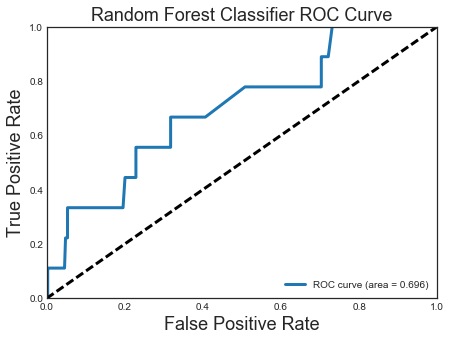

In [118]:
plt.figure(figsize=[7,5])
plt.plot(rfc_FPR[1], rfc_TPR[1], label='ROC curve (area = %0.3f)' % rfc_ROC_AUC[1], linewidth=3)
plt.plot([0, 1], [0, 1], 'k--', linewidth=3)
plt.xlim([0.0, 1])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Random Forest Classifier ROC Curve', fontsize=18)
plt.legend(loc="lower right")
plt.show()